In [1]:
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import openpyxl

import os
import requests
from lxml import html
from bs4 import BeautifulSoup
import warnings

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import urbanpy as up
import contextily as ctx

import io

pd.set_option('display.max_rows',999)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

warnings.filterwarnings("ignore")
#import unicodedata
#import gzip

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
distances = pd.read_excel('C:/Users/Franco/Python/CAF/files/distances.xlsx', index_col = 0)

In [4]:
cwpops = pd.read_excel('C:/Users/Franco/Python/CAF/files/cwpops.xlsx', index_col = [0,1])

In [5]:
ejd = pd.read_excel('C:/Users/Franco/Python/CAF/files/analisis_ejd.xlsx',  sheet_name='Sheet1 (2)')

In [6]:
ejd = ejd.rename(columns={'Pais':'Country','Ciudad':'City'})

In [7]:
#Creo DICT para poder cambiar las siglas de los paises por los nomrbes de los paises

a = list(ejd.loc[:,'Country'].unique())

b = [
 'Brasil',
 'Costa Rica',
 'Argentina',
 'Paraguay',
 'Uruguay',
 'Mexico',
 'Peru',
 'Ecuador',
 'Bolivia',
 'Panama',
 'Venezuela',
 'Chile',
 'Colombia']

b = sorted(b)

nombres = dict(zip(a, b))

nombres['PER'] = 'Peru'
nombres['PRY'] = 'Paraguay'

In [8]:
ejd = ejd.replace({"Country": nombres}).set_index(['Country','City'])

In [9]:
ejd = ejd.reset_index()

In [10]:
ejd.loc[ejd['Country']=='Mexico','City'] = ejd.loc[ejd['Country'] == 'Mexico']['City'].str.replace('Zona metropolitana de ','').str.replace('Zona metropolitana del ','')

In [11]:
ejd = ejd.set_index(['Country','City'])

In [12]:
#a = cwpops.loc['Mexico'].join(ejd.loc['Mexico'],how='inner').index.tolist()

#cwpops.loc['Mexico'].join(ejd.loc['Mexico'],how='outer').drop(index=a)

In [13]:
dic = pd.read_excel('C:/Users/Franco/Python/CAF/files/Diccionario.xlsx',header=1,usecols='B',nrows=10)

dic.columns = ['actividad']

dic['sn'] = 's' + dic['actividad'].str[:2]

dic['sn'] = dic['sn'].str.replace(" ","")

dic['actividad'] = dic['actividad'].str[5:]

dic = dic.rename(columns={'sn':'principal_sector'})

Nueva base Garganta: eph

In [14]:
eph = pd.read_excel('c:/Users/Franco/Python/CAF/files/eph/{}'.format(os.listdir("c:/Users/Franco/Python/CAF/files/eph")[2]),header=[4,5]).dropna(how='all').dropna(axis=1,how='all')

In [15]:
eph = eph.drop(columns=eph.columns[:3].tolist())

In [16]:
eph[('Country','Country')] = np.nan

In [17]:
eph = eph.rename(columns={'Unnamed: 3_level_1':'City'},level=1).rename(columns={'Unnamed: 3_level_0':'City'},level=0)

In [18]:
eph = eph.rename(columns={'Unnamed: 4_level_0':'Salario Horario (PPP 2011)'},level=0)

In [19]:
eph.loc[(eph[('City','City')].str.contains('total ciudades')),('Country','Country')] = eph.loc[(eph[('City','City')].str.contains('total ciudades')),('City','City')].apply(lambda x: x.split(' ',1)[0])

In [20]:
eph[('Country','Country')] = eph[('Country','Country')].ffill()

In [21]:
eph.loc[eph[('Country','Country')]=='Mexico',('City','City')] = eph.loc[eph[('Country','Country')] == 'Mexico'][('City','City')].str.replace('Zona metropolitana de ','').str.replace('Zona metropolitana del ','')

In [22]:
eph[('City','City')][eph[('Country','Country')]=='Colombia']=eph[('City','City')].str.title()

In [23]:
eph = eph.replace({('City','City'):{'Pedro Domingo Murillo (La Paz y el Alto)':'Pedro Domingo Murillo/La Paz y el Alto','Tomas Frías':'Tomas Frías/Potosí','Panama Oeste Arraiján':'Panama Arraiján','Panama Oeste La Chorrera':'Panama La Chorrera','chincha/Chincha Alta':'Chincha/Chincha Alta'}})

In [24]:
#eph.loc[:,[('Country','Country'),('City','City')]].droplevel(level=0,axis=1)
#eph[[('Country','Country'),('City','City')]] = 
#eph[[('Country','Country'),('City','City')]].droplevel(level=1,axis=1)
eph['pais'] = eph[('Country','Country')].to_frame().droplevel(level=0,axis=1)
eph['ciudad'] = eph[('City','City')].to_frame().droplevel(level=0,axis=1)

In [25]:
eph = eph.drop(columns=[('Country','Country'),('City','City')]).rename(columns={'pais':'Country','ciudad':'City'}).set_index(['Country','City'])

In [26]:
idx = pd.IndexSlice

In [27]:
mylist = ['Gran Area Metropolitana',
'Montevideo',
'Canelones',
'Ciudad Del Plata']

In [28]:
eph.loc[eph.index.get_level_values(1).str.contains('Área Metropolitana',regex=False),:].reset_index()['City'].tolist()

['Central  (incluye Gran Área Metropolitana)',
 'Montevideo (Área Metropolitana)',
 'Canelones Área Metropolitana (gran parte de Canelones y Ciudad de la Costa, y otros)',
 'Ciudad del Plata (Área Metropolitana)']

In [29]:
mydict = dict(zip(eph.loc[eph.index.get_level_values(1).str.contains('Área Metropolitana',regex=False),:].reset_index()['City'].tolist(),mylist))

In [30]:
eph = eph.reset_index().replace({eph.reset_index().columns[1]:mydict}).set_index(['Country','City'])

In [62]:
[eph[eph.columns[20]],eph[eph.columns[21]]] = [(eph.iloc[:,20] * eph.iloc[:,19] / (eph.iloc[:,20] + eph.iloc[:,21])), (eph.iloc[:,21] * eph.iloc[:,19] / (eph.iloc[:,20] + eph.iloc[:,21]))]

### Base cutoff

In [31]:
def get_wages_from_cutoff(city_index, cutoff):
    city_wage = cwpops.drop_duplicates('index1').loc[city_index]['estimated_citywage']
    distan = distances[(distances['Country'] == city_index[0])
                            &(distances['City A'] == city_index[1])
                            &(distances['parsed_duration'] <= cutoff)].drop_duplicates('City B')

    nearby_cities = [(x,y) for x,y in distan[['Country','City B']].values.tolist()]
    if len(nearby_cities) == 0:
        return city_wage
    else:
        nearby_wages = cwpops.loc[nearby_cities]['estimated_citywage'].sum()
        return nearby_wages + city_wage

In [32]:
def get_countryshare_from_cutoff(city_index, cutoff, share_out = True):
    nearwages = get_wages_from_cutoff(city_index, cutoff = cutoff)
    country_wages = cwpops.groupby('Country')['estimated_citywage'].sum().loc[city_index[0]]
    share = nearwages/country_wages
    if share_out == True:
        return share
    else:
        return nearwages

In [33]:
shares_cutoff = pd.DataFrame(index = cwpops.index)

In [34]:
shares_cutoff['index1'] = shares_cutoff.index
for i in range(10):
    shares_cutoff['cutoff_' + str(i)] = shares_cutoff['index1'].apply(lambda x: get_countryshare_from_cutoff(x , cutoff = i))

In [35]:
shares_cutoff = pd.concat([shares_cutoff, shares_cutoff.mean().to_frame(('Promedios','Promedios')).T])

### Acomodar el tema 'Distances' a km

In [36]:
distances['Distance2'] = distances['Distance']

In [37]:
distances.loc[(distances['Distance'].str.contains(' ft| m')),'Distance2'] = '0 km'

In [38]:
distances['distance_km'] = distances['Distance2'].apply(lambda x: x.replace(' km',''))

In [39]:
distances['distance_km'] = distances['distance_km'].astype('float')

In [40]:
del distances['Distance2']

Parsed time in traffic

In [41]:
distances['dit_elementos'] = distances['Duration in traffic'].apply(lambda x: len(re.split('day|hour|mins|seconds',x)))

In [42]:
distances['duration_traffic'] = np.nan

for i, row in distances.iterrows():
    if 'second' in row['Duration in traffic']:
        distances.loc[i,'duration_traffic']  = float(0)
    elif 'mins' in row['Duration in traffic'] and 'hour' not in row['Duration in traffic']:
        if len(row['Duration in traffic'].replace(' mins','')) > 1:
            distances.loc[i,'duration_traffic']  = float('0.'+row['Duration in traffic'].replace(' mins',''))*100/60
        else:
            distances.loc[i,'duration_traffic']  = float('0.0'+row['Duration in traffic'].replace(' mins',''))*100/60
    elif 'hour' in row['Duration in traffic'] and 'day' not in row['Duration in traffic']:
        if len(row['Duration in traffic'].split(' hour ')[1].replace(' mins','')) > 1:
            distances.loc[i,'duration_traffic'] = float(row['Duration in traffic'].split(' hour ')[0])+float('.'+row['Duration in traffic'].split(' hour ')[1].replace(' mins',''))*100/60
        else:
            distances.loc[i,'duration_traffic'] = float(row['Duration in traffic'].split(' hour ')[0])+float('.0'+row['Duration in traffic'].split(' hour ')[1].replace(' mins',''))*100/60
    elif 'day' in row['Duration in traffic']:
        a = re.split(' day | hour | mins',row['Duration in traffic'])
        if len(a[2]) > 1:
            distances.loc[i,'duration_traffic']  = float(a[0])*24+float(a[1])+float('.'+a[2])*100/60
        else:
            distances.loc[i,'duration_traffic']  = float(a[0])*24+float(a[1])+float('.0'+a[2])*100/60

Tabla Ancha

In [51]:
ta = pd.read_excel(r'C:\Users\Franco\Python\CAF\files\tabla ancha 2\tabla_ancha.xlsx',sheet_name='HH')

In [52]:
ta['pais2'] = ta['pais2'].str.title()

In [53]:
ta = ta.rename(columns={'pais2':'Country','Ciudad':'City'}).set_index(['Country','City'])

ta = ta.reset_index().replace({'City':{'Pedro Domingo Murillo (La Paz y el Alto)':'Pedro Domingo Murillo/La Paz y el Alto','Tomas Frías':'Tomas Frías/Potosí','Panama Oeste Arraiján':'Panama Arraiján','Panama Oeste La Chorrera':'Panama La Chorrera','chincha/Chincha Alta':'Chincha/Chincha Alta'}})

ta['City'][ta['Country']=='Colombia']=ta['City'].str.title()

ta.loc[ta['Country']=='Mexico','City'] = ta['City'][ta['Country']=='Mexico'].str.replace('Zona metropolitana de ','').str.replace('Zona metropolitana del ','')

ta = ta.set_index(['Country','City'])

# Definición de cantidad de ciudades disponibles

['share_emp_s1',
 'share_emp_s2',
 'share_emp_s3',
 'share_emp_s4',
 'share_emp_s5',
 'share_emp_s6',
 'share_emp_s7',
 'share_emp_s8',
 'share_emp_s9',
 'share_emp_s10',
 'HH',
 'Hhpais',
 'HHc/HHp']

In [93]:
merge = cwpops.loc[:,'pops'].to_frame().join(eph.loc[:,[('Salario Horario (PPP 2011)','Salario Horario (PPP 2011)'),('Tasa de Desempleo','Total')]+eph.columns[19:25].tolist()].droplevel(1,axis=1),how='inner').join(ta.loc[:,ta.columns[12:22].tolist()+[ta.columns[-3]]],how='inner').join(shares_cutoff.iloc[:,[1,-1]],how='inner')

In [94]:
merge['pops'] = merge['pops'] / 1000000

In [95]:
merge = merge.rename(columns={'pops':'Población estimada (millones)'})

In [96]:
corr_df = merge.reset_index().drop(['Country','City'], axis=1).corr()

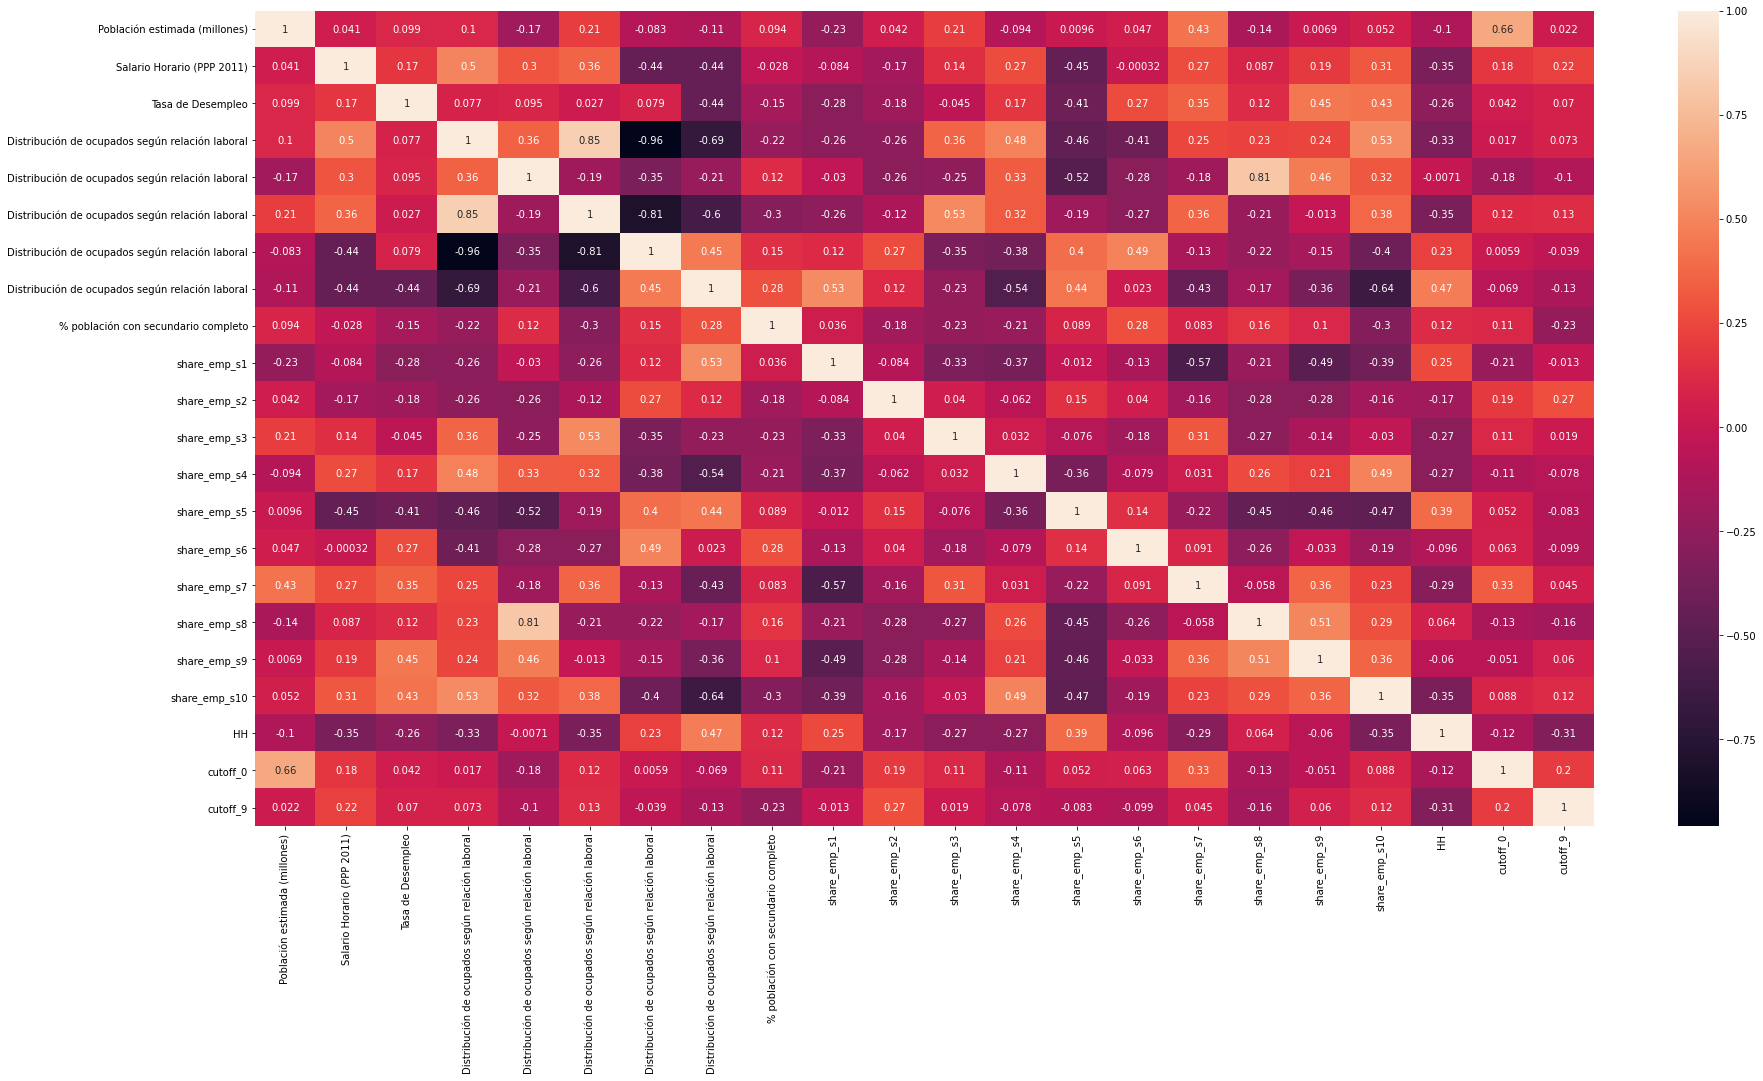

In [97]:
plt.figure(figsize=(30,15))
sns.heatmap(corr_df, annot=True)
plt.show()

Calcular brechas salariales

In [305]:
mylist = [('Mexico','Valle de México'), ('Argentina','Ciudad de Buenos Aires'), ('Brasil','Sao Paulo') , ('Chile','Región Metropolitana de Santiago'), ('Colombia','Bogota'), ('Peru','Callao y Lima') , ('Uruguay','Montevideo') , ('Paraguay','Asunción') , ('Bolivia','Pedro Domingo Murillo/La Paz y el Alto') , ('Ecuador','Quito')]

In [306]:
capitales = merge.loc[mylist,merge.columns[1]].reset_index().set_index('Country').drop(columns='City')

In [307]:
merge = merge.join(capitales,how='left',rsuffix=' (ciudad principal)')

In [308]:
merge['Brecha salarial (ciudad principal)'] = merge[merge.columns[1]] / merge[merge.columns[-1]]

La base Merge es entonces la base 

In [202]:
count = merge.iloc[:,0].groupby('Country').count().to_frame().rename(columns={'Población estimada (millones)':'Cantidad de Ciudades'})

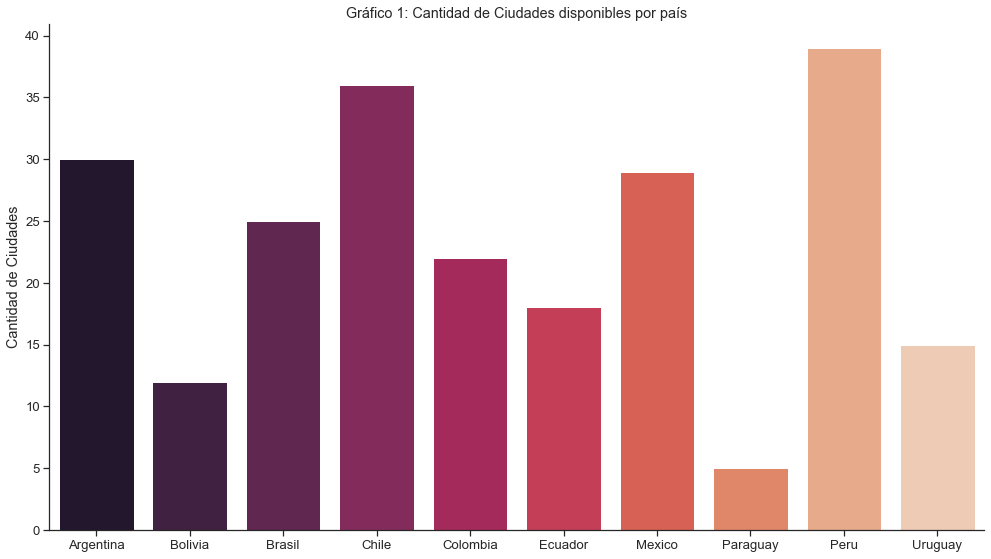

In [205]:
fig, ax = plt.subplots(figsize=(14,8)) #,constrained_layout=True
sns.barplot(x=count.index.tolist(), y='Cantidad de Ciudades', data=count , palette='rocket').set_title('Gráfico 1: Cantidad de Ciudades disponibles por país')

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
#plt.ticklabel_format(style='plain', axis='x')
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion 2/images/count.png",bbox_inches='tight')
plt.tight_layout()

In [119]:
merge.describe()

,pops,Salario Horario (PPP 2011),Tasa de Desempleo,ratio_Agro,ratio_Baja Tec,ratio_Resto Ind,cutoff_0,cutoff_9
count,239.0,239.0,239.0,239.0,239.0,227.0,239.0,239.0
mean,"823,754.7",5.0,7.2,1.0,1.0,1.0,0.0,0.4
std,"2,103,485.9",1.4,4.0,0.8,0.5,0.6,0.1,0.3
min,"5,770.0",2.6,0.4,0.1,0.2,0.1,0.0,0.0
25%,"103,199.5",4.0,3.8,0.4,0.6,0.6,0.0,0.1
50%,"244,836.0",4.8,6.7,0.8,0.9,0.8,0.0,0.4
75%,"673,115.5",5.7,10.3,1.3,1.2,1.3,0.0,0.8
max,"20,996,000.0",9.6,20.1,7.0,3.0,4.1,0.6,1.0


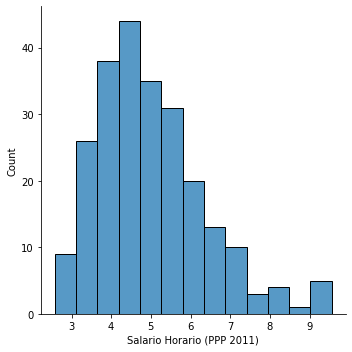

In [120]:
sns.displot(data=merge, x=merge.columns[1])
plt.ticklabel_format(style='plain', axis='x')

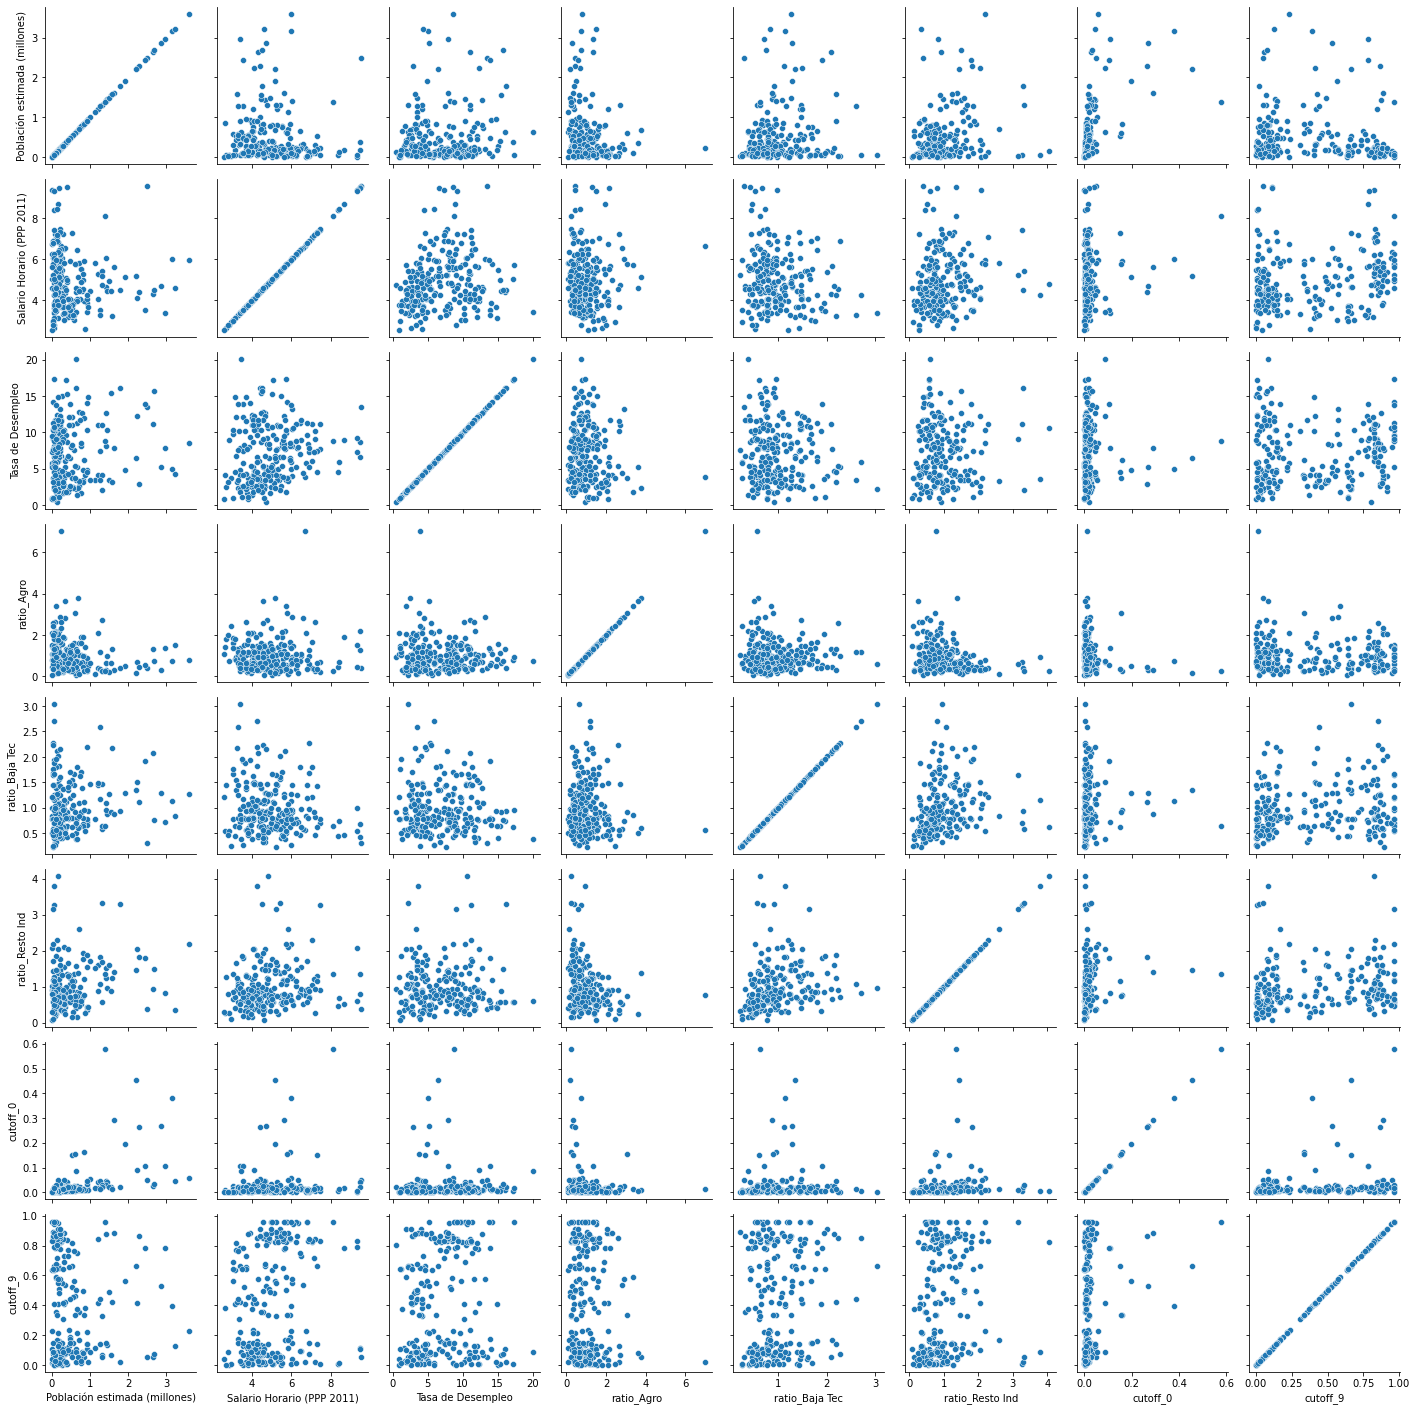

In [227]:
g = sns.PairGrid(merge)
g.map(sns.scatterplot)

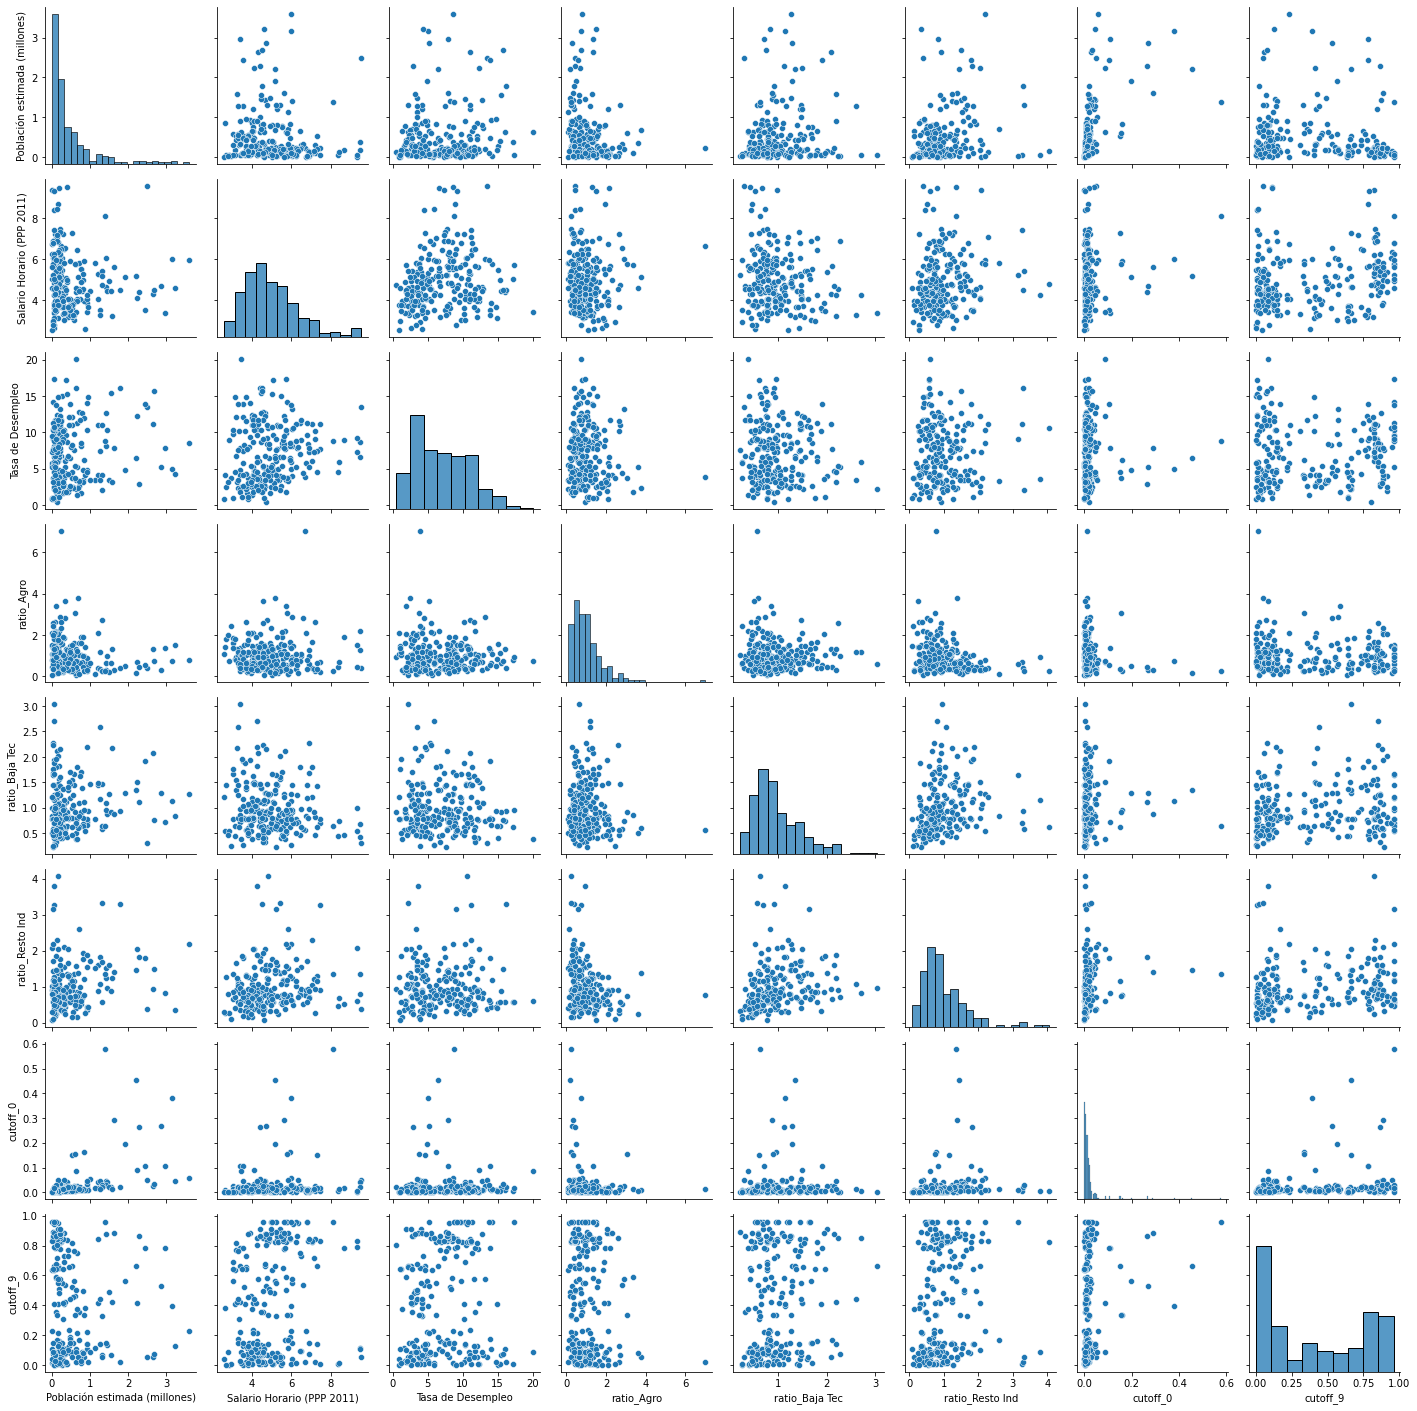

In [228]:
g = sns.PairGrid(merge)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

In [121]:
%%capture
merge.dtypes

# Sectores: se eliminan de esta base a las ciudades de mas de 5 millones de habitantes (segun aglomerados) y tomamos las ciudades con mayor población (arriba del percentil 50)

In [309]:
msa = pd.read_excel('files/aglomerados/msa.xlsx',index_col=[0,1]).reset_index().replace({'Brazil':'Brasil'})

In [310]:
msa['City'] = msa['City'].str.replace('ã','a')
msa['City'] = msa['City'].str.replace('â','a')

msa = msa.replace({'City':{'Puebla':'Puebla-Tlaxcala'}})

mydict={'Córdoba':'Gran Cordoba','Mendoza':'Gran Mendoza','Tucumán':'Gran Tucuman-Tafi Viejo','Rosario':'Gran Rosario','Buenos Aires':'Partidos del GBA'}
msa = msa.replace({'City':mydict})

msa['City'] = msa['City'].str.replace('á','a',regex=False).str.replace('é','e',regex=False).str.replace('í','i',regex=False).str.replace('ó','o',regex=False).str.replace('ú','u',regex=False).str.replace('â','a',regex=False)

mydict={'Norte Catarinense':'Florianopolis','Santa Cruz de la Sierra':'Andrés Ibañez/Santa Cruz de la Sierra','Cochabamba':'Cercado/Cochabamba','La Paz':'Pedro Domingo Murillo/La Paz y el Alto'}
msa = msa.replace({'City':mydict})

notlist = ['United States','Canada']

msa_latam = msa.loc[~msa['Country'].isin(notlist)]

msa_latam = msa_latam.sort_values(['Country','City']).set_index(['Country','City'])

msa_latam['pops'] = msa_latam['pops'] / 1000000

msa_latam = msa_latam.rename(columns={'pops':'Población estimada (millones)'})

In [240]:
#msa_latam.loc[msa_latam['Población estimada (millones)']>5,:]

Esta tabla esta corregida

In [234]:
#mylist = ['Valle de México', 'Partidos del GBA', 'Belo Horizonte', 'Sao Paulo', 'Rio de Janeiro', 'Región Metropolitana de Santiago', 'Bogota', 'Callao y Lima']
#merge.loc[idx[:,mylist],merge.columns[:3]].to_html(r"C:\Users\Franco\Python\CAF\Entregables\Informes\seleccion\seleccion 2\images\over_pop.html")

In [311]:
msa = msa.set_index(['Country','City'])

In [312]:
merge = merge.merge(msa.loc[:,'pops'],left_index=True,right_index=True,how='left').rename(columns={'pops':'Población Área Metropolitana'})
merge['Población Área Metropolitana'] = merge['Población Área Metropolitana'].astype('int',errors='ignore')

In [313]:
mylist = ['Valle de México', 'Ciudad de Buenos Aires', 'Partidos del GBA', 'Belo Horizonte', 'Sao Paulo', 'Rio de Janeiro', 'Región Metropolitana de Santiago', 'Bogota', 'Callao y Lima']
merge = merge.reset_index().loc[~merge.reset_index()['City'].isin(mylist),:].set_index(['Country','City'])

In [314]:
merge['Población Área Metropolitana'] = merge['Población Área Metropolitana']/1000000

In [315]:
merge['Población max'] = merge.loc[:,['Población Área Metropolitana','Población estimada (millones)']].max(axis=1)

In [63]:
medianas = merge.groupby('Country')['Población max'].quantile(0.5).to_frame()

In [64]:
merge = merge.join(medianas,rsuffix=' mediana pais')

In [65]:
merge_filtro = merge.loc[merge['Población max']>=merge[merge.columns[-1]],:]

In [99]:
count = merge_filtro.iloc[:,0].groupby('Country').count().to_frame().rename(columns={'Población estimada (millones)':'Cantidad de Ciudades'})

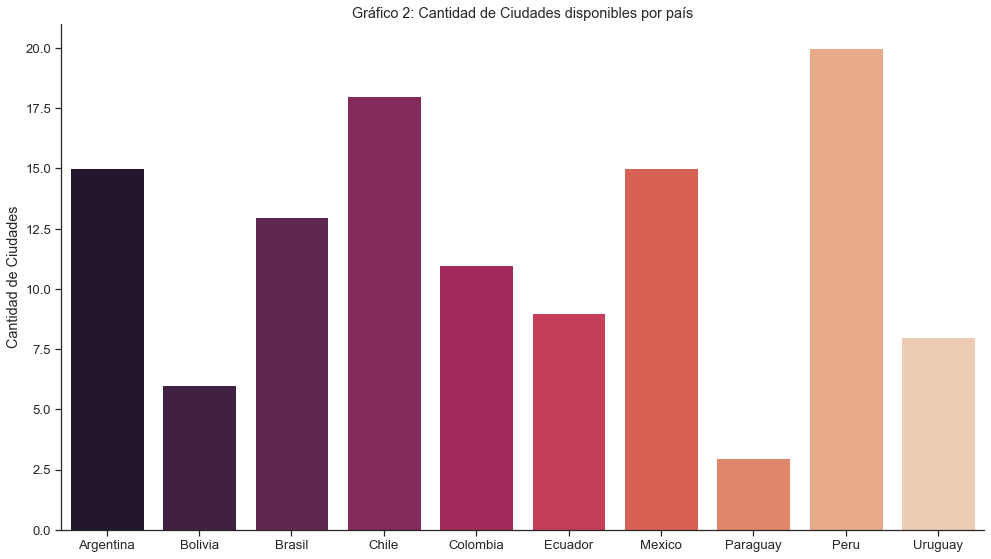

In [101]:
fig, ax = plt.subplots(figsize=(14,8)) #,constrained_layout=True
sns.barplot(x=count.index.tolist(), y='Cantidad de Ciudades', data=count , palette='rocket').set_title('Gráfico 2: Cantidad de Ciudades disponibles por país')

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
#plt.ticklabel_format(style='plain', axis='x')
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion 2/images/count2.png",bbox_inches='tight')
plt.tight_layout()

In [90]:
# Q de ciudades para trabajar para cada pais 
#mydict = {
#'Argentina' : 15
#,'Brasil' : 15
#,'Colombia' : 15
#,'Mexico' : 15
#,'Chile': 10
#,'Peru': 10
#,'Ecuador' : 5
#,'Bolivia' : 3
#,'Paraguar' : 3
#,'Uruguay' : 3}

# Tema ratios

In [68]:
ta_sel = ta.iloc[:,33:43].join(merge_filtro.iloc[:,-2],how='inner')

In [69]:
ta_medias = ta_sel.groupby('Country').mean()

Agro

In [70]:
ta_agro = ta_sel.loc[:,['Población max','Agro']].join(ta_medias.loc[:,['Agro']],how='left',rsuffix='_promedio_pais')

In [71]:
ta_agro['Ratio Agro'] = ta_agro['Agro'] / ta_agro['Agro_promedio_pais']

In [72]:
p = ta_agro.loc[idx[['Argentina','Brasil','Colombia','Mexico'],:],:].sort_values(['Country','Agro'],ascending =[True,False]).groupby('Country').head(5)

In [73]:
s = ta_agro.loc[idx[['Chile','Peru','Paraguay','Uruguay','Ecuador','Bolivia'],:],:].sort_values(['Country','Agro'],ascending =[True,False]).groupby('Country').head(2)

In [74]:
agro = p.append(s)

In [109]:
agro.rename(columns={'Población max':'Población estimada (millones)','Agro':'Participación sector agropecuario en M.S.','Agro_promedio_pais':'Promedio País','Ratio Agro':'Relación'}).to_html(r"C:\Users\Franco\Python\CAF\Entregables\Informes\seleccion\seleccion 2\images\pre_agro.html")

In [191]:
sel_agro = agro.groupby('Country').head(1).append(agro.loc[['Argentina','Brasil','Colombia','Mexico']].sort_values(['Country','Población max'],ascending=[True,False]).groupby('Country').head(1)).reset_index().drop_duplicates(subset=['Country','City']).set_index(['Country','City']).sort_values(['Country','Agro'],ascending=[True,False])
sel_agro = sel_agro.iloc[:,0].to_frame().join(shares_cutoff.loc[:,'cutoff_8'],how='inner').join(eph.loc[:,[('Salario Horario (PPP 2011)','Salario Horario (PPP 2011)'),('% Asalariados Informales','Total'),('Tasa de Desempleo','Total'),('% población con secundario completo','Total'),eph.columns[-4]]],how='inner').join(merge.loc[:,'Brecha salarial (ciudad principal)'],how='left').rename(
    columns={'cutoff_8':'Proporción masa salarial en < 8hs','pops':'Población estimada',    ('% Asalariados Informales', 'Total'):'% informalidad',('Tasa de Desempleo', 'Total'):'% desempleo',('% población con secundario completo','Total'):'% Secundario Completo',('% población con superior completo', 'Total'):'% Superior Completo',('Salario Horario (PPP 2011)','Salario Horario (PPP 2011)'):'Salario Hora USD (PPP 2011)','Población max':'Población (millones)','Brecha salarial (ciudad principal)':'Brecha: Salario / Salario ciudad principal'})

In [193]:
cols = sel_agro.columns.tolist()
cols = [cols[0]] + [cols[2]] + [cols[-1]] + cols[3:-1] + [cols[1]]

In [194]:
sel_agro = sel_agro[cols]

In [196]:
sel_agro.to_html('C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion 2/images/agro.html')

In [212]:
#x = agro.iloc[:,[0,-1]].join(shares_cutoff.loc[:,'cutoff_8'],how='inner').join(eph.loc[:,[('Salario Horario (PPP 2011)','Salario Horario (PPP 2011)'),('% Asalariados Informales','Total'),('Tasa de Desempleo','Total'),('% población con secundario completo','Total'),eph.columns[-4]]],how='inner').join(merge.loc[:,'Brecha salarial (ciudad principal)'],how='left').rename(
#    columns={'cutoff_8':'Proporción masa salarial en < 8hs','pops':'Población estimada',    ('% Asalariados Informales', 'Total'):'% informalidad',('Tasa de Desempleo', 'Total'):'% desempleo',('% población con secundario completo','Total'):'% Secundario Completo',('% población con superior completo', 'Total'):'% Superior Completo',('Salario Horario (PPP 2011)','Salario Horario (PPP 2011)'):'Salario Hora USD (PPP 2011)','Población max':'Población (millones)','Brecha salarial (ciudad principal)':'Brecha: Salario / Salario ciudad principal'})

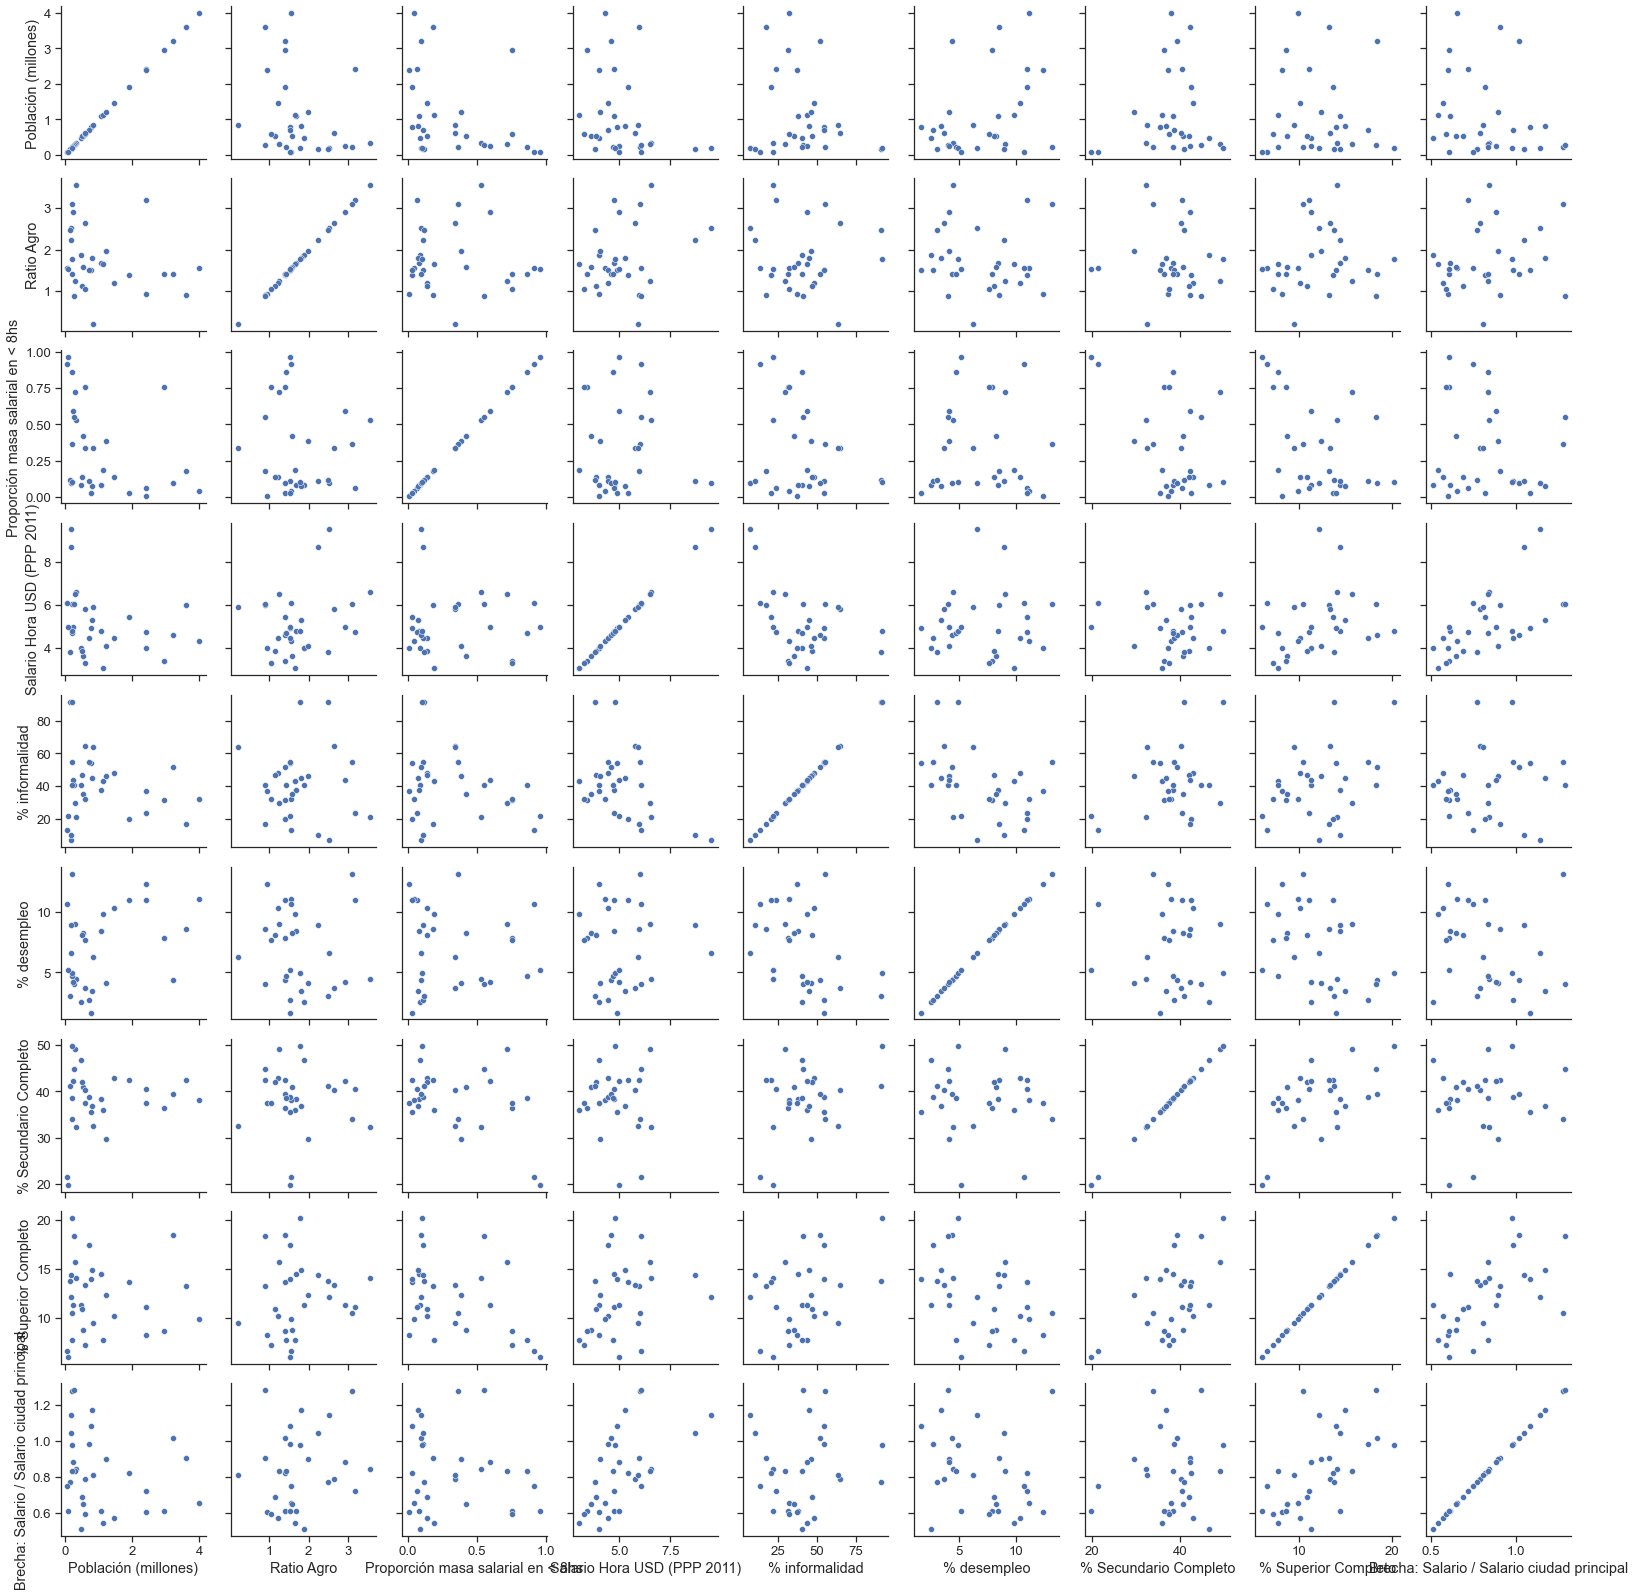

In [213]:
#g = sns.PairGrid(x)
#g.map(sns.scatterplot)

Ind_baja

In [269]:
ta_baja_tec = ta_sel.loc[:,['Población max','Baja Tec']].join(ta_medias.loc[:,['Baja Tec']],how='left',rsuffix='_promedio_pais')

In [270]:
ta_baja_tec['Ratio Baja Tec'] = ta_baja_tec['Baja Tec'] / ta_baja_tec['Baja Tec_promedio_pais']

In [271]:
p = ta_baja_tec.loc[idx[['Argentina','Brasil','Colombia','Mexico'],:],:].sort_values(['Country','Baja Tec'],ascending =[True,False]).groupby('Country').head(5)

In [272]:
s = ta_baja_tec.loc[idx[['Chile','Peru','Paraguay','Uruguay','Ecuador','Bolivia'],:],:].sort_values(['Country','Baja Tec'],ascending =[True,False]).groupby('Country').head(2)

In [273]:
baja = p.append(s)

In [274]:
baja.rename(columns={'Población max':'Población estimada (millones)','Baja Tec':'Participación sector Baja Tec en M.S.','Baja Tec_promedio_pais':'Promedio País','Ratio Baja Tec':'Relación'}).to_html(r"C:\Users\Franco\Python\CAF\Entregables\Informes\seleccion\seleccion 2\images\pre_Baja Tec.html")

In [275]:
sel_baja = baja.groupby('Country').head(1).append(baja.loc[['Argentina','Brasil','Colombia','Mexico']].sort_values(['Country','Población max'],ascending=[True,False]).groupby('Country').head(1)).reset_index().drop_duplicates(subset=['Country','City']).set_index(['Country','City']).sort_values(['Country','Baja Tec'],ascending=[True,False])

In [276]:
sel_baja = sel_baja.append(baja.loc[[('Colombia','Bucaramanga'),('Brasil','Vitoria')]]).sort_values(['Country','Baja Tec'],ascending=[True,False])

In [277]:
sel_baja = sel_baja.iloc[:,0].to_frame().join(shares_cutoff.loc[:,'cutoff_8'],how='inner').join(eph.loc[:,[('Salario Horario (PPP 2011)','Salario Horario (PPP 2011)'),('% Asalariados Informales','Total'),('Tasa de Desempleo','Total'),('% población con secundario completo','Total'),eph.columns[-4]]],how='inner').join(merge.loc[:,'Brecha salarial (ciudad principal)'],how='left').rename(
    columns={'cutoff_8':'Proporción masa salarial en < 8hs','pops':'Población estimada',    ('% Asalariados Informales', 'Total'):'% informalidad',('Tasa de Desempleo', 'Total'):'% desempleo',('% población con secundario completo','Total'):'% Secundario Completo',('% población con superior completo', 'Total'):'% Superior Completo',('Salario Horario (PPP 2011)','Salario Horario (PPP 2011)'):'Salario Hora USD (PPP 2011)','Población max':'Población (millones)','Brecha salarial (ciudad principal)':'Brecha: Salario / Salario ciudad principal'})

In [278]:
cols = sel_baja.columns.tolist()
cols = [cols[0]] + [cols[2]] + [cols[-1]] + cols[3:-1] + [cols[1]]

In [279]:
sel_baja = sel_baja[cols]

In [281]:
sel_baja.to_html('C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion 2/images/Baja Tec.html')

Resto Ind

In [282]:
ta_resto = ta_sel.loc[:,['Población max','Resto Ind']].join(ta_medias.loc[:,['Resto Ind']],how='left',rsuffix='_promedio_pais')

In [283]:
ta_resto['Ratio Resto Ind'] = ta_resto['Resto Ind'] / ta_resto['Resto Ind_promedio_pais']

In [284]:
p = ta_resto.loc[idx[['Argentina','Brasil','Colombia','Mexico'],:],:].sort_values(['Country','Resto Ind'],ascending =[True,False]).groupby('Country').head(5)

In [285]:
s = ta_resto.loc[idx[['Chile','Peru','Paraguay','Uruguay','Ecuador','Bolivia'],:],:].sort_values(['Country','Resto Ind'],ascending =[True,False]).groupby('Country').head(2)

In [286]:
resto = p.append(s)

In [288]:
resto.rename(columns={'Población max':'Población estimada (millones)','Resto Ind.':'Participación sector Resto Ind. en M.S.','Resto Ind_promedio_pais':'Promedio País','Ratio Resto Ind':'Relación'}).to_html(r"C:\Users\Franco\Python\CAF\Entregables\Informes\seleccion\seleccion 2\images\pre_resto.html")

In [290]:
sel_resto = resto.groupby('Country').head(1).append(resto.loc[['Argentina','Brasil','Colombia','Mexico']].sort_values(['Country','Población max'],ascending=[True,False]).groupby('Country').head(1)).reset_index().drop_duplicates(subset=['Country','City']).set_index(['Country','City']).sort_values(['Country','Resto Ind'],ascending=[True,False])

In [291]:
sel_resto = sel_resto.iloc[:,0].to_frame().join(shares_cutoff.loc[:,'cutoff_8'],how='inner').join(eph.loc[:,[('Salario Horario (PPP 2011)','Salario Horario (PPP 2011)'),('% Asalariados Informales','Total'),('Tasa de Desempleo','Total'),('% población con secundario completo','Total'),eph.columns[-4]]],how='inner').join(merge.loc[:,'Brecha salarial (ciudad principal)'],how='left').rename(
    columns={'cutoff_8':'Proporción masa salarial en < 8hs','pops':'Población estimada',    ('% Asalariados Informales', 'Total'):'% informalidad',('Tasa de Desempleo', 'Total'):'% desempleo',('% población con secundario completo','Total'):'% Secundario Completo',('% población con superior completo', 'Total'):'% Superior Completo',('Salario Horario (PPP 2011)','Salario Horario (PPP 2011)'):'Salario Hora USD (PPP 2011)','Población max':'Población (millones)','Brecha salarial (ciudad principal)':'Brecha: Salario / Salario ciudad principal'})

In [292]:
cols = sel_resto.columns.tolist()
cols = [cols[0]] + [cols[2]] + [cols[-1]] + cols[3:-1] + [cols[1]]

In [293]:
sel_resto = sel_resto[cols]

In [295]:
sel_resto.to_html('C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion 2/images/Resto Ind.html')

## Aglomerados

In [337]:
sectores = sel_agro.append(sel_baja).append(sel_resto).reset_index().drop_duplicates(subset=['Country','City']).set_index(['Country','City']).sort_values(['Country','City'],ascending=[True,False])

In [338]:
aglo = merge.iloc[:,[1,2,6,7,9,-1]]

In [339]:
cols = aglo.columns.tolist()

In [343]:
cols = [cols[-1]] + [cols[0]] + [cols[1]] + [cols[4]] + [cols[3]]

In [344]:
aglo = aglo[cols]

In [345]:
notlist = sectores.index.tolist()

In [346]:
aglo = aglo.loc[~aglo.index.isin(notlist),:]

In [350]:
aglo_sel = aglo.loc[['Argentina','Brasil','Colombia','Mexico']].sort_values(['Country','Población max'],ascending=[True,False]).groupby('Country').head(2)

In [353]:
aglo_sel = aglo_sel.iloc[:,0].to_frame().join(shares_cutoff.loc[:,'cutoff_8'],how='left').join(eph.loc[:,[('Salario Horario (PPP 2011)','Salario Horario (PPP 2011)'),('% Asalariados Informales','Total'),('Tasa de Desempleo','Total'),('% población con secundario completo','Total'),eph.columns[-4]]],how='left').join(merge.loc[:,'Brecha salarial (ciudad principal)'],how='left').rename(
    columns={'cutoff_8':'Proporción masa salarial en < 8hs','pops':'Población estimada',    ('% Asalariados Informales', 'Total'):'% informalidad',('Tasa de Desempleo', 'Total'):'% desempleo',('% población con secundario completo','Total'):'% Secundario Completo',('% población con superior completo', 'Total'):'% Superior Completo',('Salario Horario (PPP 2011)','Salario Horario (PPP 2011)'):'Salario Hora USD (PPP 2011)','Población max':'Población (millones)','Brecha salarial (ciudad principal)':'Brecha: Salario / Salario ciudad principal'})

In [399]:
aglo_sel.to_html('C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion 2/images/aglo.html')

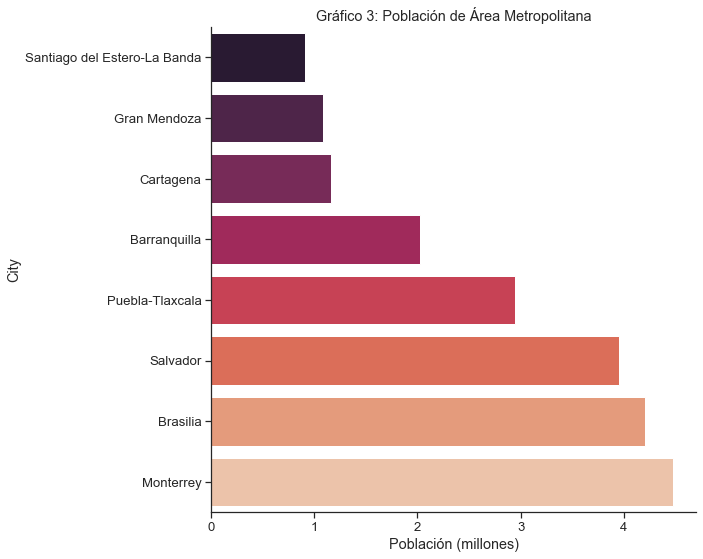

In [361]:
fig, ax = plt.subplots(figsize=(10,8)) #,constrained_layout=True
sns.barplot(x='Población (millones)', y=aglo_sel.sort_values('Población (millones)').index.get_level_values(1), data=aglo_sel.sort_values('Población (millones)') , palette='rocket' , orient='h' ).set_title('Gráfico 3: Población de Área Metropolitana')

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
plt.ticklabel_format(style='plain', axis='x')
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion 2/images/aglomerados.png",bbox_inches='tight')
plt.tight_layout()

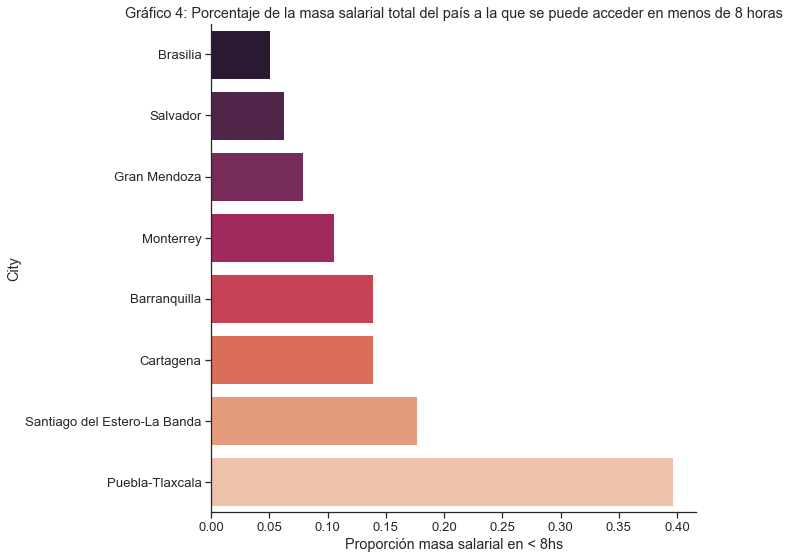

In [402]:
fig, ax = plt.subplots(figsize=(10,8)) #,constrained_layout=True
sns.barplot(x='Proporción masa salarial en < 8hs', y=aglo_sel.sort_values('Proporción masa salarial en < 8hs').index.get_level_values(1), data=aglo_sel.sort_values('Proporción masa salarial en < 8hs') , palette='rocket' , orient='h' ).set_title('Gráfico 4: Porcentaje de la masa salarial total del país a la que se puede acceder en menos de 8 horas')

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
plt.ticklabel_format(style='plain', axis='x')
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion 2/images/aglomerados_lejania.png",bbox_inches='tight')
plt.tight_layout()

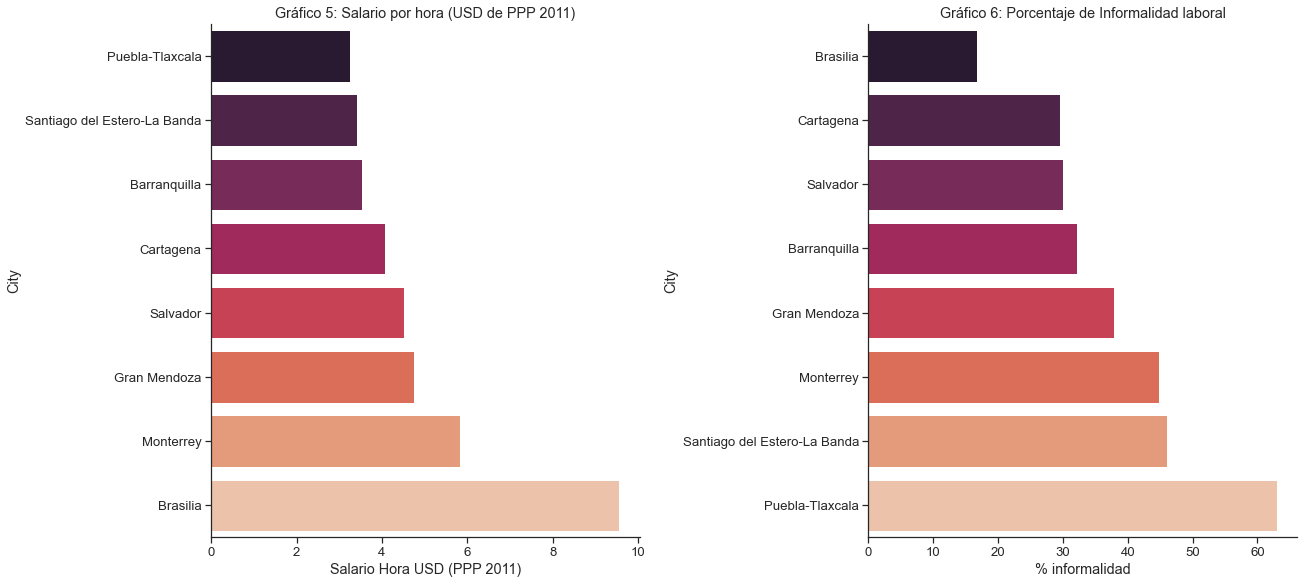

In [363]:
f, axes = plt.subplots(1, 2,figsize=(18,8),constrained_layout=True)

sns.barplot(x='Salario Hora USD (PPP 2011)', y=aglo_sel.sort_values('Salario Hora USD (PPP 2011)').index.get_level_values(1) , data=aglo_sel.sort_values('Salario Hora USD (PPP 2011)'),palette='rocket' , orient='h' , ax=axes[0]).set_title('Gráfico 5: Salario por hora (USD de PPP 2011)')
sns.barplot(x='% informalidad', y=aglo_sel.sort_values('% informalidad').index.get_level_values(1) , data=aglo_sel.sort_values('% informalidad'),palette='rocket' , orient='h'  ,ax=axes[1]).set_title('Gráfico 6: Porcentaje de Informalidad laboral')

sns.set(font_scale=1.2)
sns.set_style("ticks") #, {"xtick.major.size": 8, "ytick.major.size": 3}
sns.despine()
plt.ticklabel_format(style='plain', axis='x')

#axes[1].get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion 2/images/aglomerados_23.png",bbox_inches='tight') 
#plt.tight_layout()

## cercania mercados

In [369]:
notlist = sectores.index.append(aglo_sel.index).tolist()

In [377]:
cerca= merge.iloc[:,[1,2,6,7,9,-1]]
cerca = cerca.loc[~cerca.index.isin(notlist),:]

In [378]:
cerca['crec_ms'] = (cerca['cutoff_9'] / cerca['cutoff_0']) - 1

In [385]:
cerca = cerca.reset_index().drop_duplicates(subset=['Country','City']).set_index(['Country','City'])

In [415]:
cerca

Salario Horario (PPP 2011)  \
Country   City                                                                 
Argentina Bahia Blanca-Cerri                                            6.50   
          Comodoro Rivadavia-Rada Tilly                                 6.67   
          Concordia                                                     4.24   
          Corrientes                                                    4.34   
          Formosa                                                       4.09   
          Gran Catamarca                                                4.24   
          Gran La Plata                                                 5.75   
          Gran Parana                                                   5.17   
          Gran Resistencia                                              3.77   
          Gran San Juan                                                 3.99   
          Gran Santa Fe                                                 4.88   
          Jujuy-Palpala                                                 3.91   
          La Rioja                                                      4.26   
          Posadas                                                       4.34   
          Rawson-Trelew                                                 6.05   
          Rio Cuarto                                                    5.44   
          Rio Gallegos                                                  7.23   
          Salta                                                         3.99   
          San Luis-El Chorrillo                                         4.64   
          San Nicolas-Villa Constitucion                                4.80   
          Santa Rosa-Toay                                               5.32   
          Ushuaia-Rio Grande                                            7.44   
          Viedma-Carmen de Patagones                                    4.90   
Bolivia   Cercado/Oruro                                                 6.05   
          Cercado/Tarija                                                5.39   
          Cercado/Trinidad                                              5.34   
          Nicolas Suarez/Cobija                                         5.98   
          Obispo Santisteban/Montero                                    5.74   
          Oropeza                                                       5.02   
          Pedro Domingo Murillo/La Paz y el Alto                        4.71   
          Quillacollo                                                   5.20   
          Vaca Diez                                                     4.48   
Brasil    Aracaju                                                       4.43   
          Belem                                                         3.99   
          Boa Vista                                                     5.50   
          Campo Grande                                                  5.55   
          Cuiaba                                                        5.51   
          Curitiba                                                      5.98   
          Florianopolis                                                 5.94   
          Joao Pessoa                                                   4.56   
          Macapa                                                        5.05   
          Maceio                                                        3.89   
          Natal                                                         4.44   
          Palmas                                                        4.66   
          Porto Velho                                                   5.07   
          Recife                                                        4.44   
          Rio Branco                                                    5.02   
          Sao Luis                                                      3.68   
          Teresina                                

In [416]:
sel_cerca = cerca.loc[['Argentina','Brasil','Colombia','Mexico']].loc[(cerca['Población max']>0.25),:].sort_values(['Country','crec_ms'],ascending=[True,False]).groupby('Country').head(5)

In [418]:
sel_cerca = sel_cerca.iloc[:,[-2,-1]].join(shares_cutoff.loc[:,'cutoff_8'],how='left').join(eph.loc[:,[('Salario Horario (PPP 2011)','Salario Horario (PPP 2011)'),('% Asalariados Informales','Total'),('Tasa de Desempleo','Total'),('% población con secundario completo','Total'),eph.columns[-4]]],how='left').join(merge.loc[:,'Brecha salarial (ciudad principal)'],how='left').rename(
    columns={'cutoff_8':'Proporción masa salarial en < 8hs','pops':'Población estimada',    ('% Asalariados Informales', 'Total'):'% informalidad',('Tasa de Desempleo', 'Total'):'% desempleo',('% población con secundario completo','Total'):'% Secundario Completo',('% población con superior completo', 'Total'):'% Superior Completo',('Salario Horario (PPP 2011)','Salario Horario (PPP 2011)'):'Salario Hora USD (PPP 2011)','Población max':'Población (millones)','Brecha salarial (ciudad principal)':'Brecha: Salario / Salario ciudad principal','crec_ms':'Multiplicador de Masa Salarial'})

In [419]:
sel_cerca.to_html("C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion 2/images/cerca.html")

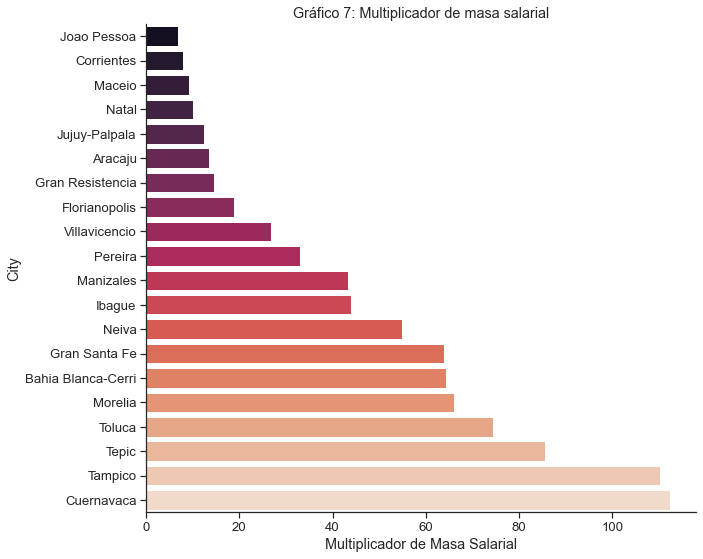

In [422]:
fig, ax = plt.subplots(figsize=(10,8)) #,constrained_layout=True
sns.barplot(x='Multiplicador de Masa Salarial', y=sel_cerca.sort_values('Multiplicador de Masa Salarial').index.get_level_values(1), data=sel_cerca.sort_values('Multiplicador de Masa Salarial') , palette='rocket' , orient='h' ).set_title('Gráfico 7: Multiplicador de masa salarial')

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.despine()
plt.ticklabel_format(style='plain', axis='x')
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion 2/images/cerca.png",bbox_inches='tight')
plt.tight_layout()

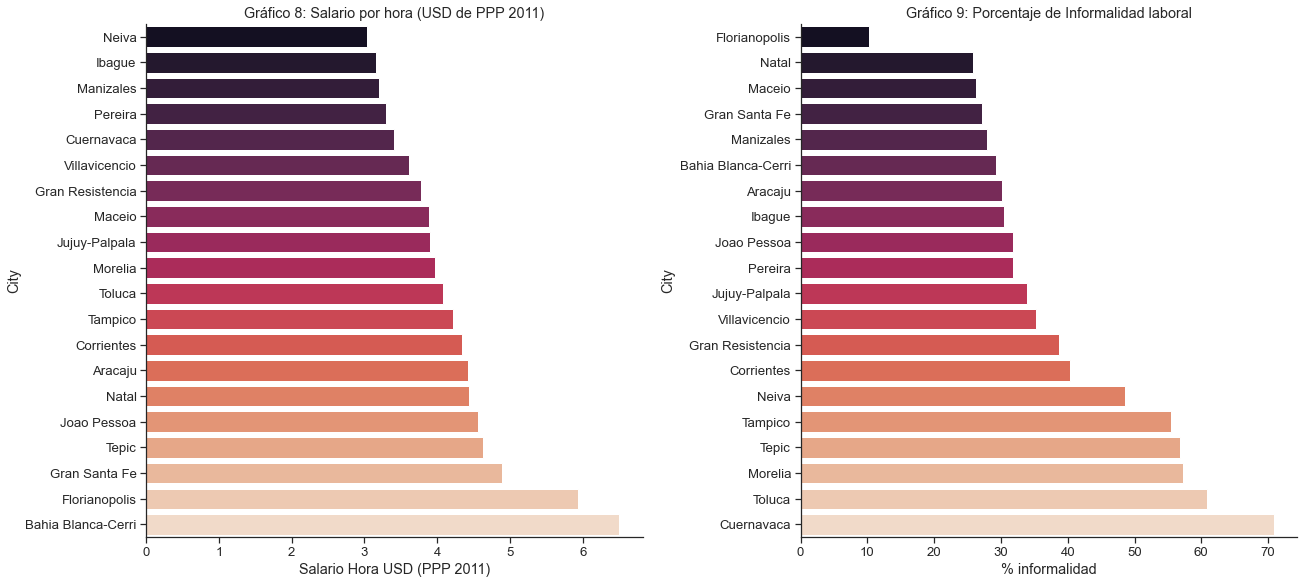

In [414]:
f, axes = plt.subplots(1, 2,figsize=(18,8),constrained_layout=True)

sns.barplot(x='Salario Hora USD (PPP 2011)', y=sel_cerca.sort_values('Salario Hora USD (PPP 2011)').index.get_level_values(1) , data=sel_cerca.sort_values('Salario Hora USD (PPP 2011)'),palette='rocket' , orient='h' , ax=axes[0]).set_title('Gráfico 8: Salario por hora (USD de PPP 2011)')
sns.barplot(x='% informalidad', y=sel_cerca.sort_values('% informalidad').index.get_level_values(1) , data=sel_cerca.sort_values('% informalidad'),palette='rocket' , orient='h'  ,ax=axes[1]).set_title('Gráfico 9: Porcentaje de Informalidad laboral')

sns.set(font_scale=1.2)
sns.set_style("ticks") #, {"xtick.major.size": 8, "ytick.major.size": 3}
sns.despine()
plt.ticklabel_format(style='plain', axis='x')

#axes[1].get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig("C:/Users/Franco/Python/CAF/Entregables/Informes/seleccion/seleccion 2/images/cerca_23.png",bbox_inches='tight') 
#plt.tight_layout()